# CAB BOOKINGS

## **1. OVERVIEW**

Cab booking system is a process where renting a cab is automated through an app in a city. People use the app to book a cab from one location to another. The scope of this project is to gain insights of the supply and demand, and to **maximize the service provdied with a minimum wait times**

As a data scientist, we are provided with train and test datasets. Train dataset would be used to analyze and generalize the model, test dataset would be used to validated the model's effectiveness on an unseen sample

Since this is a supervised regression ML, we are provided with the below independent and dependent features

* datetime - hourly date + timestamp
* season - summer, autumn, spring, winter (categorical feature)
* holiday - day is considered as a holiday or not (0/1 categorical feature)
* weekday - day is niether a weekend or holiday (0/1 categorical feature)
* weather - clear, cloudy, light rain and heavy temp (categorical feature)
* temp - temperature in Celsius
* atemp - "feels like" temperature in celsius
* humidity - relative humidity
* windspeed - wind speed
* __Bookings - number of total bookings (dependent variable)__

__PROCESS FLOW:__
* Exploratory data analysis - Univariate and Multi-variate visulizations
* Outlier analysis
* Missing value analysis
* Correlation analysis
* Feature engineering
* Grid Search/Modeling
* Regression Analysis/Predictions
* Conclusion

#### Library Imports

In [158]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import statsmodels.api as sm
import xgboost as xgb
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
train = pd.concat([pd.read_csv('train.csv'), pd.read_csv('train_label.csv', header=None)], axis=1)
test = pd.concat([pd.read_csv('test.csv'), pd.read_csv('test_label.csv', header=None)], axis=1)

## 2 __FEATURE ENGINEERING__

In [3]:
def preprocess(df):
    df.rename(columns={0:'Bookings'}, inplace=True)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['weekday'] = df['datetime'].apply(lambda x: x.strftime('%a'))
    df['day'] = df['datetime'].apply(lambda x: x.strftime('%d'))
    df['time'] = df['datetime'].apply(lambda x: x.strftime('%X'))
    df['month'] = df['datetime'].apply(lambda x: x.strftime('%m'))
    df['year'] = df['datetime'].apply(lambda x: x.strftime('%Y'))
    df.drop('datetime',axis=1, inplace=True)
    return df

In [4]:
train = preprocess(train)
test = preprocess(test)

In [5]:
train.weekday.unique()

array(['Wed', 'Thu', 'Fri', 'Tue', 'Sat', 'Mon', 'Sun'], dtype=object)

## 3 __EDA & Visualizations__

In [6]:
train.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,Bookings
count,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000
mean,0.028480,0.680294,20.243020,23.655552,61.649173,12.843891,193.007005
std,0.166348,0.466389,7.813494,8.501107,19.199578,8.190314,181.552211
min,0.000000,0.000000,0.820000,0.760000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,13.940000,16.665000,46.000000,7.001500,43.000000
50%,0.000000,1.000000,20.500000,24.240000,61.000000,12.998000,148.000000
75%,0.000000,1.000000,26.240000,31.060000,77.000000,16.997900,286.000000
max,1.000000,1.000000,41.000000,45.455000,100.000000,56.996900,977.000000


* Holiday and workingday features are correlated, with additional features from the date data, these 2 features could be correlated weekday feature
* humidity has min value as zero, it is highly impossible to have humidity as zero. It may be due to the value not being measured, may need to impute a value
* windspeed has min value as zero, which is possible

In [7]:
test.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,Bookings
count,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000
mean,0.028926,0.683196,20.182241,23.653214,62.835170,12.621496,185.845271
std,0.167636,0.465337,7.704978,8.369721,19.401161,8.060062,179.431987
min,0.000000,0.000000,3.280000,3.790000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,13.940000,16.665000,48.000000,7.001500,38.000000
50%,0.000000,1.000000,20.500000,24.240000,63.000000,11.001400,136.000000
75%,0.000000,1.000000,26.240000,31.060000,78.000000,16.997900,277.000000
max,1.000000,1.000000,38.540000,44.695000,100.000000,56.996900,901.000000


* Holiday and workingday features are correlated, with additional features from the date data, these 2 features could be correlated weekday feature
* humidity has min value as zero, it is highly impossible to have humidity as zero. It may be due to the value not being measured, may need to impute a value
* windspeed has min value as zero, which is possible

**1 Seasonal & monthly booking analysis**

Summer    2197
Fall      2189
Winter    2186
Spring    2136
Name: season, dtype: int64
Seasonal booking measurement in the train dataset is balanced
------------------
------------------
Spring    550
Winter    548
Fall      544
Summer    536
Name: season, dtype: int64
Seasonal booking measurement in the test dataset is balanced
------------------
------------------
    season month
3   Spring    01
4   Spring    02
5   Spring    03
6   Summer    04
7   Summer    05
8   Summer    06
0     Fall    07
1     Fall    08
2     Fall    09
9   Winter    10
10  Winter    11
11  Winter    12
------------------
------------------


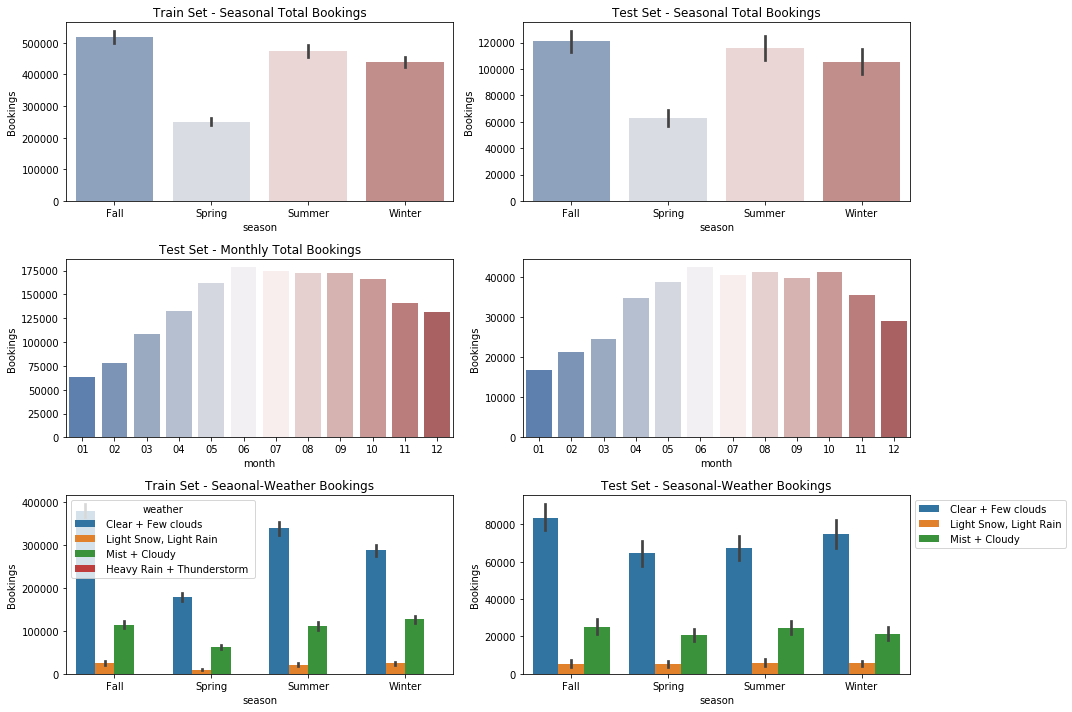

In [8]:
print(train.season.value_counts())
print('Seasonal booking measurement in the train dataset is balanced')
print('------------------')
print('------------------')
print(test.season.value_counts())
print('Seasonal booking measurement in the test dataset is balanced')
print('------------------')
print('------------------')
f, axes = plt.subplots(3, 2, figsize=(15, 10))
sns.barplot(x=train.season.sort_values(),y=train.Bookings,estimator=sum, orient='v',ax=axes[0][0], palette='vlag')
axes[0][0].set_title("Train Set - Seasonal Total Bookings")
sns.barplot(x=test.season.sort_values(),y=test.Bookings, estimator=sum, orient='v',ax=axes[0][1], palette='vlag')
axes[0][1].set_title("Test Set - Seasonal Total Bookings")
a = pd.DataFrame(train.groupby("month")["Bookings"].sum()).reset_index().sort_values(by='month')
sns.barplot(data=a,x="month",y="Bookings",ax=axes[1][0], orient='v', palette='vlag')
axes[1][0].set_title("Train Set - Monthly Total Bookings")
a = pd.DataFrame(test.groupby("month")["Bookings"].sum()).reset_index().sort_values(by='month')
sns.barplot(data=a,x="month",y="Bookings",ax=axes[1][1], orient='v', palette='vlag')
axes[1][0].set_title("Test Set - Monthly Total Bookings")
sns.barplot(x=train.season.sort_values(),y=train.Bookings, hue=train.weather, estimator=sum, orient='v',ax=axes[2][0])
axes[2][0].set_title("Train Set - Seaonal-Weather Bookings")
sns.barplot(x=train.season.sort_values(), y=test.Bookings, hue=test.weather, estimator=sum ,orient='v',ax=axes[2][1])
axes[2][1].set_title("Test Set - Seasonal-Weather Bookings")
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()

print(train.groupby(['season','month'])['Bookings'].sum().reset_index().sort_values(by='month')[['season','month']])
print('------------------')
print('------------------')

* Fall season (months Jul,Aug,Sep) has the most number of bookings, could be answered by school openings, office hour usage, etc
* Spring season (months Jan,Feb,Mar) has the least nbr of bookings, could be due to cold weather, vacation, etc
* From the month bart chart, we can observe dec-Mar bookings lower than other months, could be answered by vacation, school closings, and weather
* From the 3rd row of charts, we can observe that bookings are low when it's raining.
* we can observe that seasonal feature to be correlated to month feature

**2 Seaonsal temp, atemp, humidity and windfall analysis**

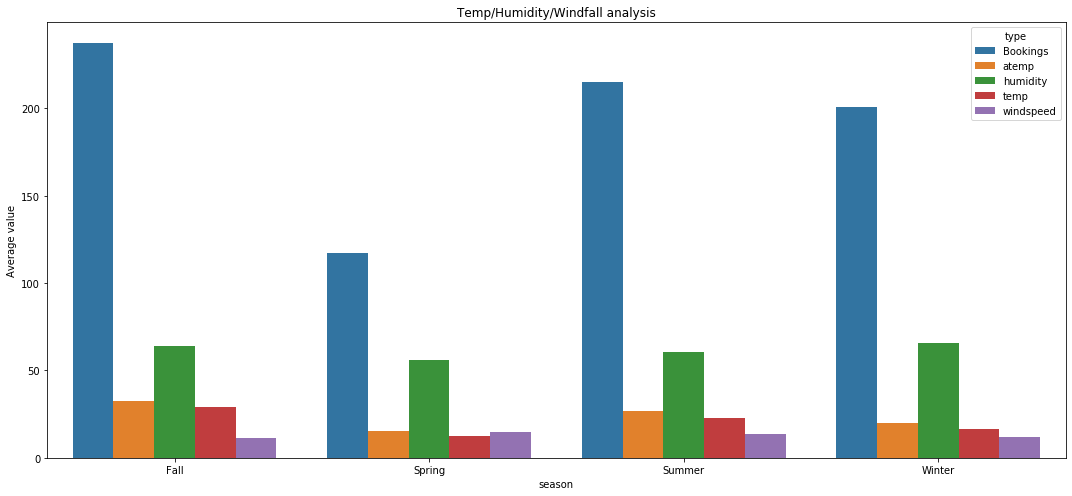

In [9]:
a = pd.DataFrame(pd.pivot_table(columns='season',values=['temp','atemp','humidity','windspeed','Bookings'], data=train).to_records())
a.rename(columns={'index':'type'}, inplace=True)
a = pd.melt(a, id_vars='type')
plt.figure(figsize=(15,7))
sns.barplot(x='variable', y='value', hue='type', data=a)
plt.xlabel('season')
plt.ylabel('Average value')
plt.title('Temp/Humidity/Windfall analysis')
plt.tight_layout()

* Average humidity and windspeed across all seasons seem to be equal
* Temp averages vary across seasons, fall season which has the highest average has the most nbr of bookings
* Both temperature features would be correlated to the nbr of bookings

**3 Hourly and Weekday analysis**

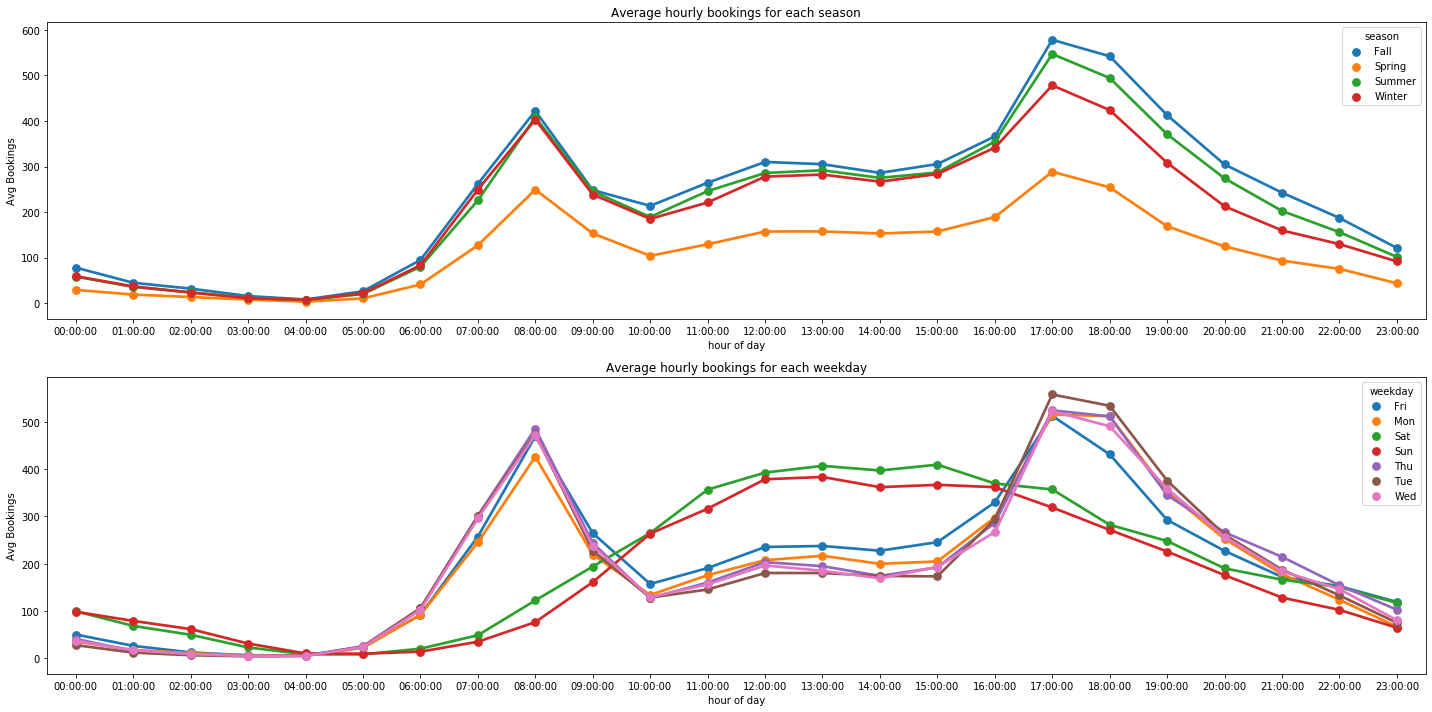

In [10]:
fig,axes= plt.subplots(2,1, figsize=(20,10))
a = train.groupby(['time','season'])['Bookings'].mean().reset_index().sort_values(by='time',ascending=True)
sns.pointplot(x="time",y="Bookings",hue='season',estimator=sum,data=a,size=5,aspect=1,ax=axes[0])
axes[0].set(xlabel='hour of day', ylabel='Avg Bookings', title='Average hourly bookings for each season')
a = train.groupby(['time','weekday'])['Bookings'].mean().reset_index().sort_values(by='time',ascending=True)
sns.pointplot(x="time",y="Bookings",hue='weekday',estimator=sum,data=a,size=5,aspect=1,ax=axes[1])
axes[1].set(xlabel='hour of day', ylabel='Avg Bookings', title='Average hourly bookings for each weekday')
plt.tight_layout()

* From the 1st chart, we can observe that between 7AM-9AM and 4PM-7PM there is a spike in the nbr of bookings, possibly due to office/school start and close hours
* From the 2nd chart, we can observe the spike in the office start and close hours during weekdays but not on weekends. During weekends, a smoother spiker from 10AM-5PM indicating people going out to eat, etc
* Hourly and weekday features can have an outcome on the nbr of bookings

**4 Year-over-Year seasonal analysis**

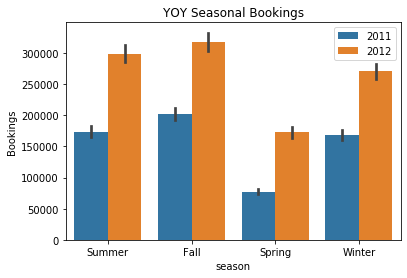

Can observe YOY booings increase across all seasons


In [11]:
sns.barplot(x='season', y='Bookings', hue='year', estimator=sum, data=train)
plt.title('YOY Seasonal Bookings')
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print('Can observe YOY booings increase across all seasons')

**5 Temp and atemp analysis**

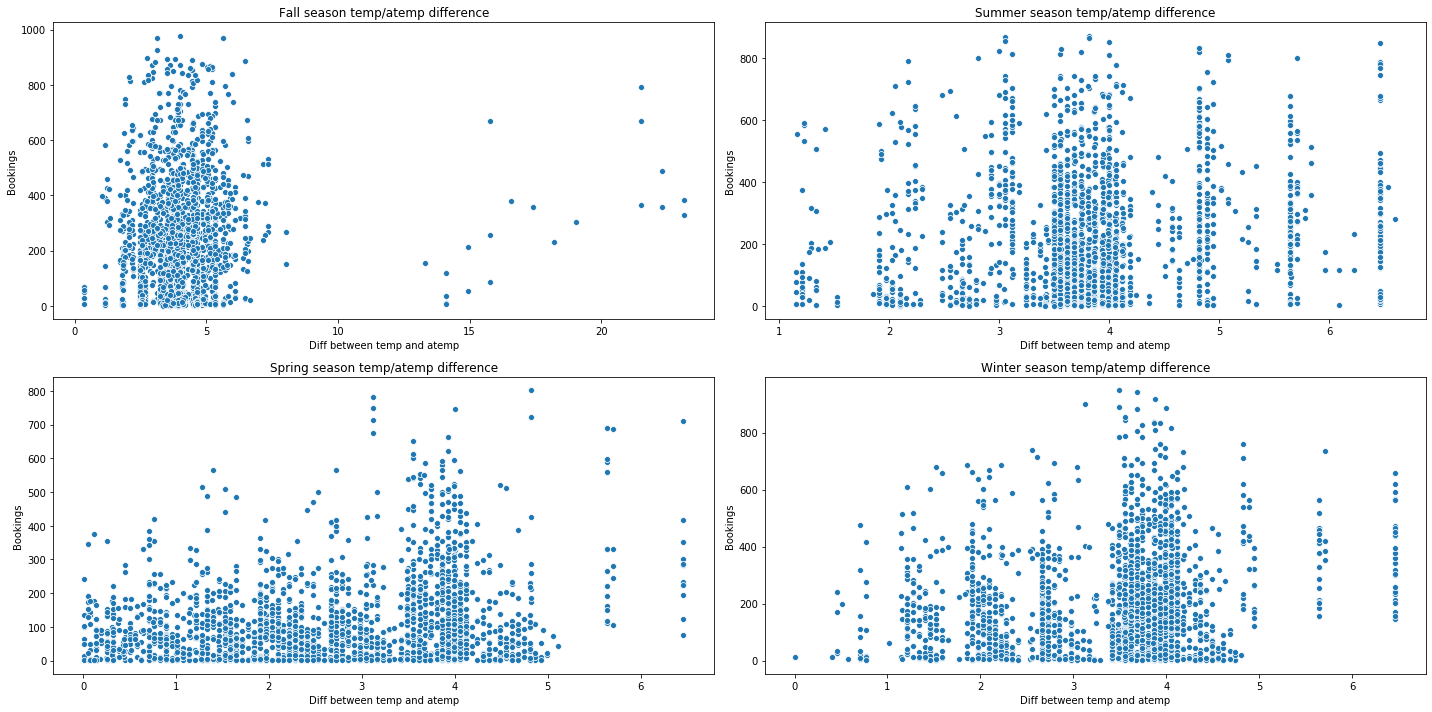

In [12]:
fig,axes= plt.subplots(2,2, figsize=(20,10))
a = train[train.season == 'Fall']
sns.scatterplot(x=np.abs(a.temp-a.atemp), y=a.Bookings, estimator=sum, ax=axes[0][0])
axes[0][0].set(xlabel='Diff between temp and atemp', ylabel='Bookings', title='Fall season temp/atemp difference')
a = train[train.season == 'Summer']
sns.scatterplot(x=np.abs(a.temp-a.atemp), y=a.Bookings, estimator=sum, ax=axes[0][1])
axes[0][1].set(xlabel='Diff between temp and atemp', ylabel='Bookings', title='Summer season temp/atemp difference')
a = train[train.season == 'Spring']
sns.scatterplot(x=np.abs(a.temp-a.atemp), y=a.Bookings, estimator=sum, ax=axes[1][0])
axes[1][0].set(xlabel='Diff between temp and atemp', ylabel='Bookings', title='Spring season temp/atemp difference')
a = train[train.season == 'Winter']
sns.scatterplot(x=np.abs(a.temp-a.atemp), y=a.Bookings, estimator=sum, ax=axes[1][1])
axes[1][1].set(xlabel='Diff between temp and atemp', ylabel='Bookings', title='Winter season temp/atemp difference')
plt.tight_layout()

* From the above 4 charts, we can observe the vast majority of temp and atemp is in a range of 0-6 celsius. Only in fall season a few bookings were made with temp differences over 10 degree celsius.

## 3 OUTLIER ANALYSIS

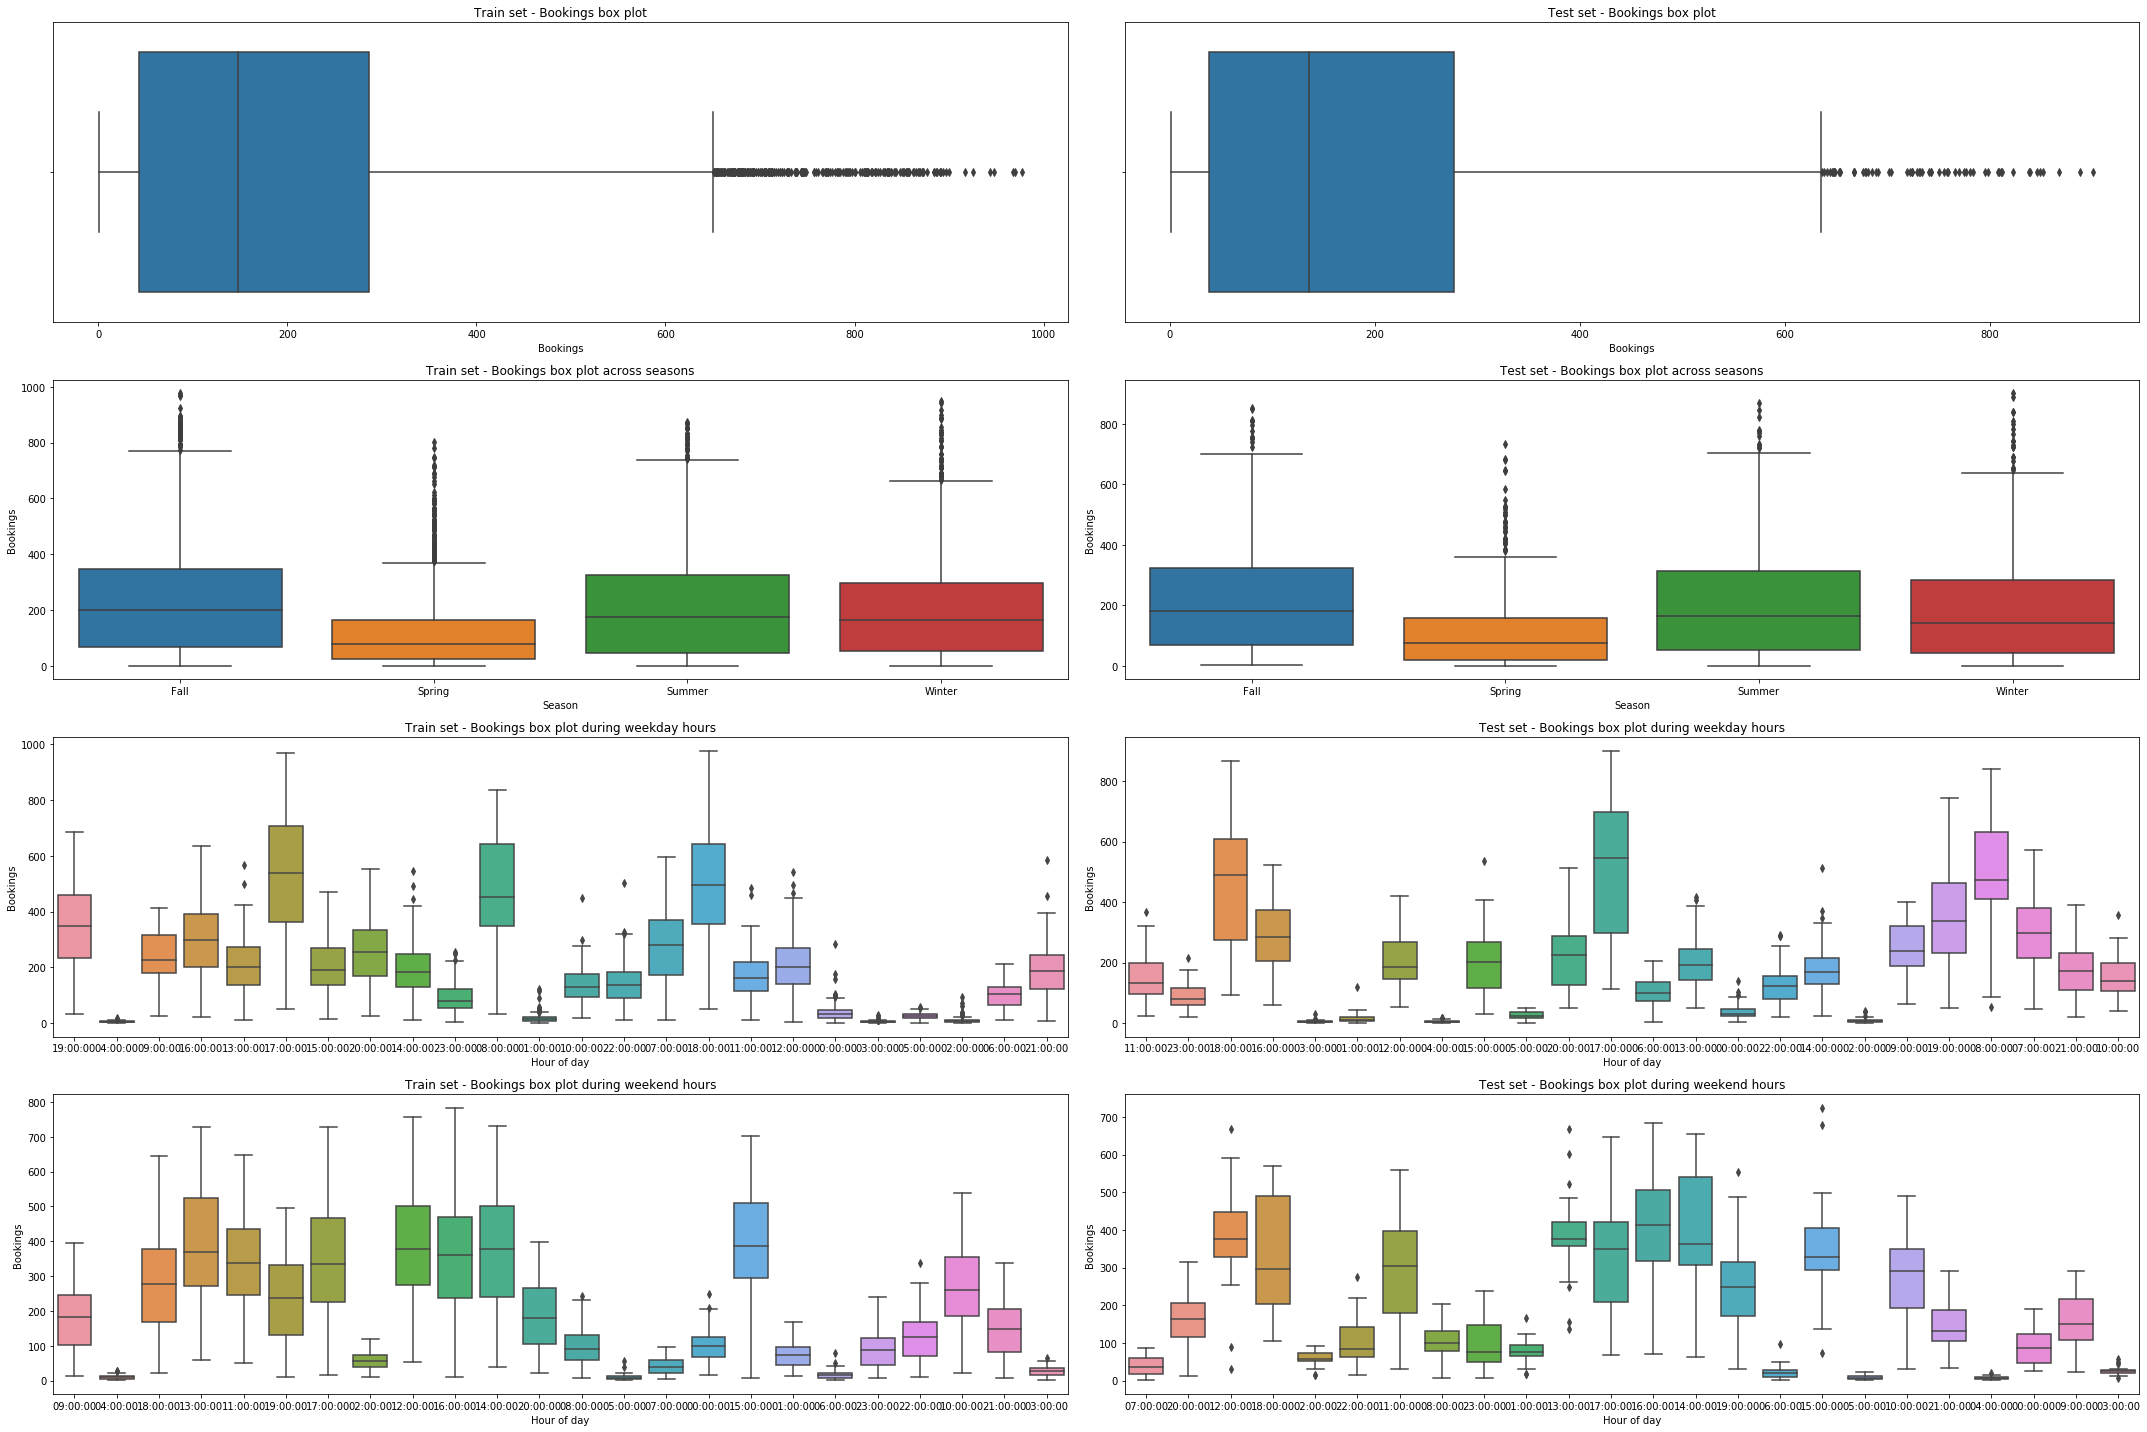

In [13]:
fig, axes = plt.subplots(4,2,figsize=(30,20))
sns.boxplot(x='Bookings',data=train,orient='h',ax=axes[0][0])
axes[0][0].set(xlabel='Bookings',title='Train set - Bookings box plot')
sns.boxplot(x='Bookings',data=test,orient='h',ax=axes[0][1])
axes[0][1].set(xlabel='Bookings',title='Test set - Bookings box plot')
sns.boxplot(y='Bookings',x='season',data=train.sort_values(by='season'),orient='v',ax=axes[1][0])
axes[1][0].set(ylabel='Bookings',xlabel='Season',title='Train set - Bookings box plot across seasons')
sns.boxplot(y='Bookings',x='season',data=test.sort_values(by='season'),orient='v',ax=axes[1][1])
axes[1][1].set(ylabel='Bookings',xlabel='Season',title='Test set - Bookings box plot across seasons')
sns.boxplot(y='Bookings',x='time',data=train[~((train.weekday == 'Sat') | (train.weekday == 'Sun'))],orient='v',ax=axes[2][0])
axes[2][0].set(ylabel='Bookings',xlabel='Hour of day',title='Train set - Bookings box plot during weekday hours')
sns.boxplot(y='Bookings',x='time',data=test[~((test.weekday == 'Sat') | (test.weekday == 'Sun'))],orient='v',ax=axes[2][1])
axes[2][1].set(ylabel='Bookings',xlabel='Hour of day',title='Test set - Bookings box plot during weekday hours')
sns.boxplot(y='Bookings',x='time',data=train[(train.weekday == 'Sat') | (train.weekday == 'Sun')],orient='v',ax=axes[3][0])
axes[3][0].set(ylabel='Bookings',xlabel='Hour of day',title='Train set - Bookings box plot during weekend hours')
sns.boxplot(y='Bookings',x='time',data=test[(test.weekday == 'Sat') | (test.weekday == 'Sun')],orient='v',ax=axes[3][1])
axes[3][1].set(ylabel='Bookings',xlabel='Hour of day',title='Test set - Bookings box plot during weekend hours')
plt.tight_layout()

* Both train and test bookings contain outliers skewed to the right based on the first 2 charts. We can also observe this phenomenon
* Spring season with low number of bookings has more outliers skewed beyond q3.
* Outliers tend to have higher influence in our predictions, more balanced train set would help us generalize the model better. outlier transformation can be performed using 3 methods: log transformation, cuberoot transformation, IQR +/- 3std range

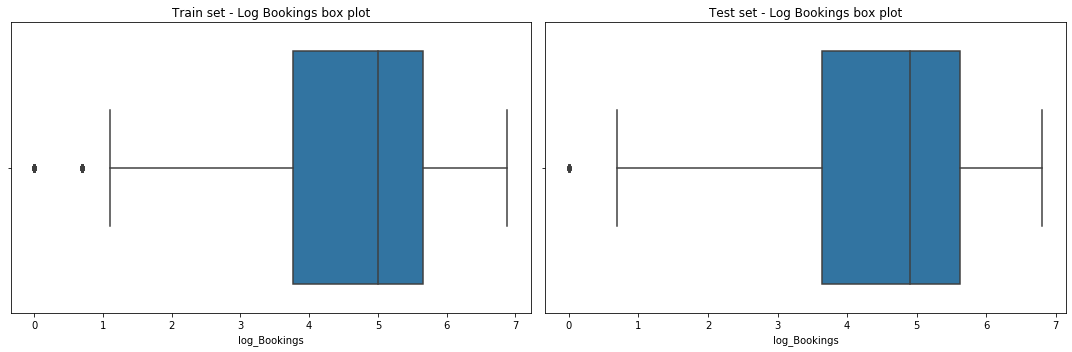

In [14]:
# OUTLIER LOG TRANSFORMATION
train['log_Bookings'] = np.log(train.Bookings)
test['log_Bookings'] = np.log(test.Bookings)
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(x='log_Bookings',data=train,orient='h',ax=axes[0])
axes[0].set(xlabel='log_Bookings',title='Train set - Log Bookings box plot')
sns.boxplot(x='log_Bookings',data=test,orient='h',ax=axes[1])
axes[1].set(xlabel='log_Bookings',title='Test set - Log Bookings box plot')
plt.tight_layout()

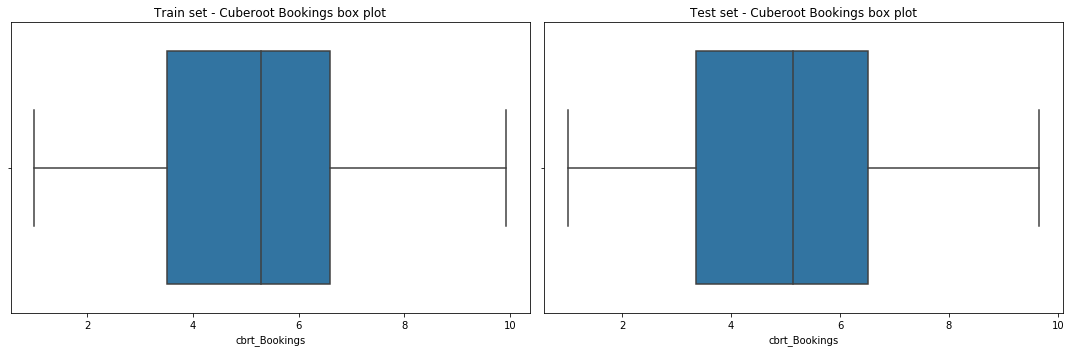

In [15]:
# OUTLIER CUBEROOT TRANSFORMATION
train['cbrt_Bookings'] = np.cbrt(train.Bookings)
test['cbrt_Bookings'] = np.cbrt(test.Bookings)
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(x='cbrt_Bookings',data=train,orient='h',ax=axes[0])
axes[0].set(xlabel='cbrt_Bookings',title='Train set - Cuberoot Bookings box plot')
sns.boxplot(x='cbrt_Bookings',data=test,orient='h',ax=axes[1])
axes[1].set(xlabel='cbrt_Bookings',title='Test set - Cuberoot Bookings box plot')
plt.tight_layout()

* Cuberoot bookings transformation contain no outliers, the data seems to be balanced. Log transformation does have some outliers
* IQR outlier treatment is not performed because we may lose valuable information when training the data during peak hours

## 4 MISSING VALUE ANALYSIS & FEATURE ENGINEERING

In [16]:
train.isna().sum()

season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
Bookings         0
weekday          0
day              0
time             0
month            0
year             0
log_Bookings     0
cbrt_Bookings    0
dtype: int64

In [17]:
test.isna().sum()

season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
Bookings         0
weekday          0
day              0
time             0
month            0
year             0
log_Bookings     0
cbrt_Bookings    0
dtype: int64

* It's highly impossible to have zero value as humidity, zero values indicate that these are missing values in train and test sets
* using the all the features (excl Bookings) the zero values are going to be imputed using backward elimination using LR

In [19]:
train['dataset'] = 'train'
test['dataset'] = 'test'

In [21]:
df = pd.concat([train, test], axis=0)
df['time'] = df['time'].apply(lambda x: x[:2])

* Transforming categorical variables to 0s/1s using get dummies: Season, Weather, Weekday, Time, Year, Month

In [22]:
df = pd.concat([df, pd.get_dummies(df.season), pd.get_dummies(df.weather), 
                              pd.get_dummies(df.weekday),
                              pd.get_dummies(df.time, prefix='hour'),
                              pd.get_dummies(df.month, prefix='month'),
                              pd.get_dummies(df.year, prefix='year')], axis=1)

In [23]:
df.drop(columns=['season', 'holiday', 'workingday', 'weather', 'weekday', 'day', 'time', 'month', 'year', 'log_Bookings'], inplace=True)

#### BACKWARD ELIMINATION IMPUTATION

In [24]:
humid_impute = df.copy()

In [25]:
humid_impute_train = humid_impute[~(humid_impute.humidity == 0)]
humid_impute_test = humid_impute[humid_impute.humidity == 0]

In [26]:
X_train = humid_impute_train.drop(columns=['dataset', 'humidity', 'Bookings', 'cbrt_Bookings']).values
y_train = humid_impute_train['humidity'].values
X_test = humid_impute_test.drop(columns=['dataset', 'humidity', 'Bookings', 'cbrt_Bookings']).values

In [27]:
def backwardElimination(x, y, x_test, sl):
    numVars = x.shape[1]
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    x_test = np.delete(x_test, j, 1)
    regressor_OLS.summary()
    return x, x_test

X_train, X_test = backwardElimination(X_train, y_train, X_test, 0.05)

In [28]:
print(X_train.shape,X_test.shape,y_train.shape)

(10864, 52) (22, 52) (10864,)


* 4 features were eliminated using backward elimination method with a p-value 0.05

In [29]:
results = sm.OLS(y_train, X_train).fit().predict(X_test)

In [30]:
humid_impute_test['humidity'] = results

In [31]:
final_df = pd.concat([humid_impute_train, humid_impute_test], axis=0)

In [32]:
train = final_df[final_df.dataset == 'train'].drop(columns=['dataset', 'Bookings'])
test = final_df[final_df.dataset == 'test'].drop(columns=['dataset', 'Bookings'])

In [35]:
len(train.columns)

58

* Final dataset has 57 independent features, and cube root bookings as the dependent feature

## 5 CORRELATION ANALYSIS

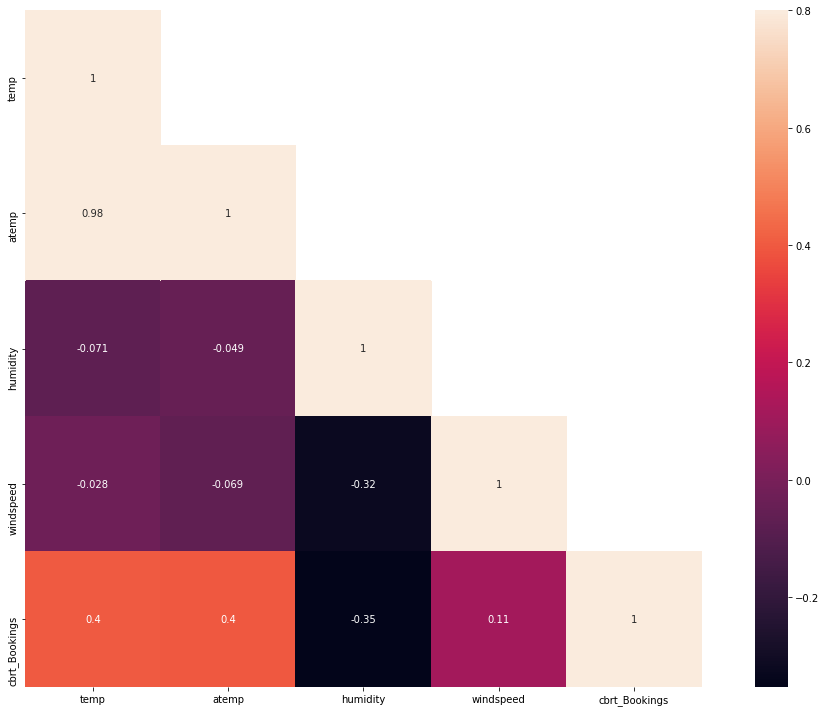

In [36]:
corrmatrix = train[['temp', 'atemp', 'humidity', 'windspeed', 'cbrt_Bookings']].corr()
mask = np.array(corrmatrix)
mask[np.tril_indices_from(mask)] = 0
fig,ax= plt.subplots(figsize=(15,10))
sns.heatmap(corrmatrix, mask=mask,vmax=.8, square=True,annot=True)
plt.tight_layout()

* Bookings is positively correlated to temp and atemp and negatively correlated to humidity.
* Atemp and Temp are highly correlated with each other, one of the features would need to be dropped for all the features to exhibit independence

## 6 CBRT BOOKINGS VS INDEPENDENT FEATURE VISUALIZATIONS

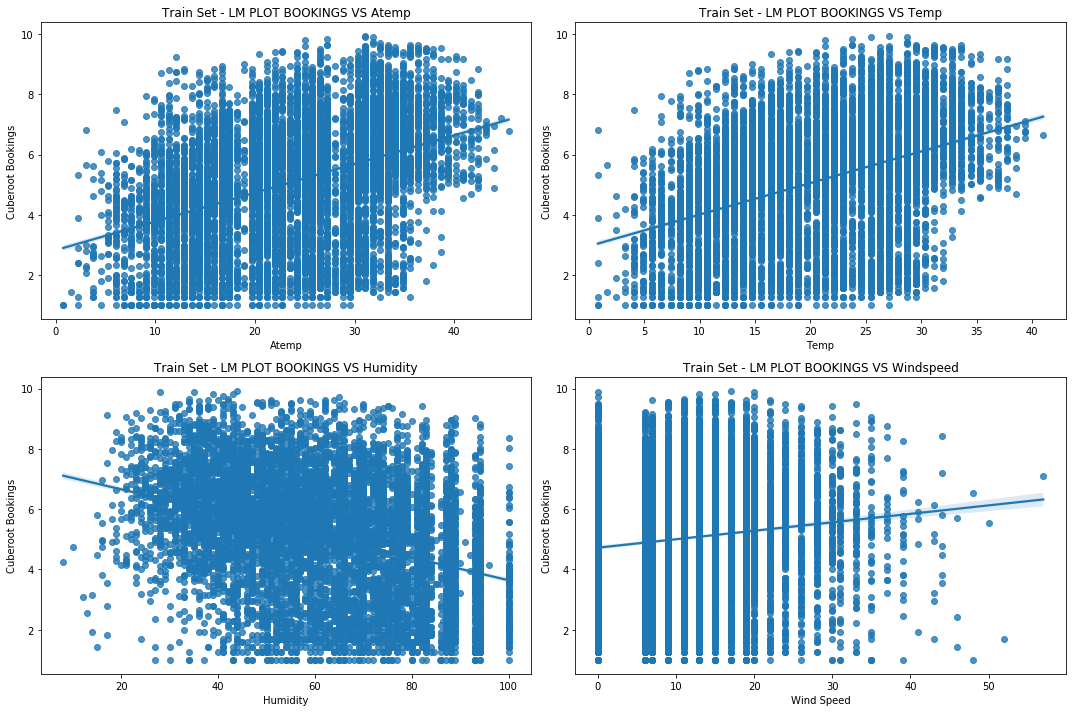

In [37]:
f, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.regplot(x=train.atemp,y=train.cbrt_Bookings,ax=axes[0][0])
axes[0][0].set(xlabel='Atemp', ylabel='Cuberoot Bookings', title="Train Set - LM PLOT BOOKINGS VS Atemp")
sns.regplot(x=train.temp,y=train.cbrt_Bookings,ax=axes[0][1])
axes[0][1].set(xlabel='Temp', ylabel='Cuberoot Bookings', title="Train Set - LM PLOT BOOKINGS VS Temp")
sns.regplot(x=train.humidity,y=train.cbrt_Bookings,ax=axes[1][0])
axes[1][0].set(xlabel='Humidity', ylabel='Cuberoot Bookings', title="Train Set - LM PLOT BOOKINGS VS Humidity")
sns.regplot(x=train.windspeed,y=train.cbrt_Bookings,ax=axes[1][1])
axes[1][1].set(xlabel='Wind Speed', ylabel='Cuberoot Bookings', title="Train Set - LM PLOT BOOKINGS VS Windspeed")
plt.tight_layout()

* We can observe a strong linear positive relationship with temp and atemp, but a flatter relationship with windspeed. Apparently the effective of windspeed would not determine the nbr of cab bookings
* We can observe a strong linear negative relationship with Humidity

#### CUBEROOT BOOKINGS DISTRIBUTION

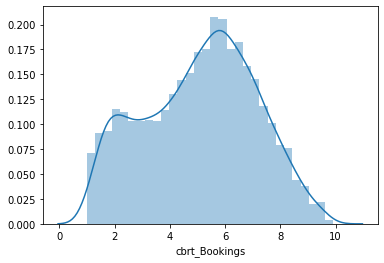

In [38]:
sns.distplot(train.cbrt_Bookings)

* From the above distribution plot, the cuberoot transformation of bookings aligns the data along a normal distribution, which is critical for any regression model

## 7 MODEL BUILDING, TUNING AND GRID SEARCH

#### REGRESSION ANALYSIS

###### 1 LINEAR REGREESION (BACKWARD ELIMINATION)

* Data preparation for linear and polynomial regression, dropping a categorical factor to avoid a dummy variable trap. eg: fall category feature can be dropped when training the model, means when summer, spring, winter are all zero, it means FALL season

In [122]:
X_train_reg = train.drop(columns=['cbrt_Bookings', 'Fall', ' Clear + Few clouds', 'Fri', 'hour_00', 'month_01', 'year_2011'])
X_test_reg = test.drop(columns=['cbrt_Bookings', 'Fall', ' Clear + Few clouds', 'Fri', 'hour_00', 'month_01', 'year_2011'])
y_train_reg = train.cbrt_Bookings
y_test_reg = test.cbrt_Bookings

In [165]:
def backwardElimination(x_train, x_test, y_train, y_test):
    x_train = sm.add_constant(x_train)
    x_test = sm.add_constant(x_test)
    numVars = x_train.shape[1] - 1 # excluding intercept
    i = 0
    while i < numVars:
        regressor_OLS = sm.OLS(y_train, x_train).fit()
        train_r2 = regressor_OLS.rsquared_adj
        r2 = r2_score(y_test, regressor_OLS.predict(x_test))
        maxVar = regressor_OLS.pvalues[~(regressor_OLS.pvalues.index == 'const')].sort_values(ascending=False)[i]
        maxFeature = regressor_OLS.pvalues[regressor_OLS.pvalues == maxVar].index
        if maxVar > 0.05:
            new_x_train = x_train.drop(columns=maxFeature)
            new_x_test = x_test.drop(columns=maxFeature)
            new_reg = sm.OLS(y_train, new_x_train).fit()
            new_r2 = r2_score(y_test, new_reg.predict(new_x_test))
            if new_r2 > r2:
                x_train = new_x_train
                x_test = new_x_test
                numVars = x_train.shape[1] - 1
                print(f'Dropped feature: {maxFeature[0]}')
            else:
                i += 1
                continue
        else:
            i += 1
            continue
    print(regressor_OLS.summary())
    
    return train_r2, r2

In [166]:
lr_results = {}
train_r2, r2 = backwardElimination(X_train_reg, X_test_reg, y_train_reg, y_test_reg)
lr_results['model'] = 'Linear Regression'
lr_results['Train_r2_score'] = train_r2
lr_results['r2_score'] = r2

Dropped feature: Sat
                            OLS Regression Results                            
Dep. Variable:          cbrt_Bookings   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     852.1
Date:                Thu, 25 Jun 2020   Prob (F-statistic):               0.00
Time:                        01:30:36   Log-Likelihood:                -11000.
No. Observations:                8708   AIC:                         2.210e+04
Df Residuals:                    8660   BIC:                         2.244e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

* From the above linear regression analysis, training and test r2 score are close to 0.80 indicating that there is a linear relationship of the independent and features
* After backward elimination, one feature was dropped

###### 2 SUPPORT VECTOR REGRESSION

* Support vector regression is to create a hyperplane, which predicts the bookings value based on the separation

In [125]:
X_train = train.drop(columns=['cbrt_Bookings'])
X_test = test.drop(columns=['cbrt_Bookings'])
y_train = train.cbrt_Bookings
y_test = test.cbrt_Bookings

In [136]:
svr_results = {}
svr = SVR()
params = {
    'kernel': ['rbf'],
    'gamma': [0.01,0.1,1],
    'C': [0.01,0.1,1,10,50]
}
svr_grid = GridSearchCV(svr, param_grid = params, n_jobs=-1, cv=5, scoring='r2')
svr_grid.fit(X_train, y_train)
svr_results['model'] = 'SVR'
svr_results['Train_r2_score'] = svr_grid.best_score_
svr_results['r2_score'] = r2_score(y_test, svr_grid.predict(X_test))
print(svr_grid.best_estimator_)

SVR(C=50, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [137]:
svr_results

{'model': 'SVR',
 'Train_r2_score': 0.7843636939490674,
 'r2_score': 0.785712159503446}

* Grid Search yiedled the best parameters for the SVR model.
* Train and test r2 score are lower than linear regression at 0.78
* With ensemble trees, we would be able to get better r2 scores

#### ENSEMBLE MODELS

Research has shown that ensemble models doesnt overfit and yields the best predictions, and scores. Below models with grid search would be used to determined the most optimal model

* Random Forest Regressor
* Extra Trees Regressor
* Gradient Boost Regressor
* XGBoost Regressor

In [159]:
def model_training(regressor, x_train, x_test, y_train, y_test, model_spec):
    model_dict = {}
    if model_spec in ['GrandientBoost', 'xgboost']:
        params = {
            'n_estimators': [100, 500, 1000],
            'learning_rate': [0.01, 0.1, 1],
            'random_state': [1]
        }
        grid = GridSearchCV(regressor, param_grid=params, n_jobs=-1, scoring='r2')
        grid.fit(x_train, y_train)
        model_dict['model'] = model_spec
        model_dict['Train_r2_score'] = grid.best_score_
        model_dict['r2_score'] = r2_score(y_test, grid.predict(x_test))
    elif model_spec in ['RandomForest', 'ExtraTress']:
        params = {
            'n_estimators': [100, 500, 1000],
            'max_features': ['auto', 'sqrt', 'log2'],
            'random_state': [1]
        }
        grid = GridSearchCV(regressor, param_grid=params, n_jobs=-1, scoring='r2')
        grid.fit(x_train, y_train)
        model_dict['model'] = model_spec
        model_dict['Train_r2_score'] = grid.best_score_
        model_dict['r2_score'] = r2_score(y_test, grid.predict(x_test))
        
    print(grid.best_params_)
    
    return model_dict

rfr = RandRandomForestRegressor()
rfr.fit(X_train, y_train)
predictions = rfr.predict(X_test)
score = r2_score(y_test, predictions)

In [152]:
rf_results = model_training(RandomForestRegressor(), X_train, X_test, y_train, y_test, 'RandomForest')

{'max_features': 'auto', 'n_estimators': 1000, 'random_state': 1}


In [154]:
extraTree_results = model_training(ExtraTreesRegressor(), X_train, X_test, y_train, y_test, 'ExtraTress')

{'max_features': 'auto', 'n_estimators': 1000, 'random_state': 1}


In [156]:
gb_results = model_training(GradientBoostingRegressor(), X_train, X_test, y_train, y_test, 'GrandientBoost')

{'learning_rate': 0.1, 'n_estimators': 1000, 'random_state': 1}


In [160]:
xgb_results = model_training(xgb.XGBRegressor(), X_train, X_test, y_train, y_test, 'xgboost')

{'learning_rate': 0.1, 'n_estimators': 1000, 'random_state': 1}


In [167]:
results = pd.DataFrame([lr_results, svr_results, rf_results, extraTree_results, gb_results, xgb_results])

In [168]:
results

,model,Train_r2_score,r2_score
0,Linear Regression,0.821251,0.809714
1,SVR,0.784364,0.785712
2,RandomForest,0.921713,0.930285
3,ExtraTress,0.933938,0.939815
4,GrandientBoost,0.942609,0.942345
5,xgboost,0.947219,0.951252


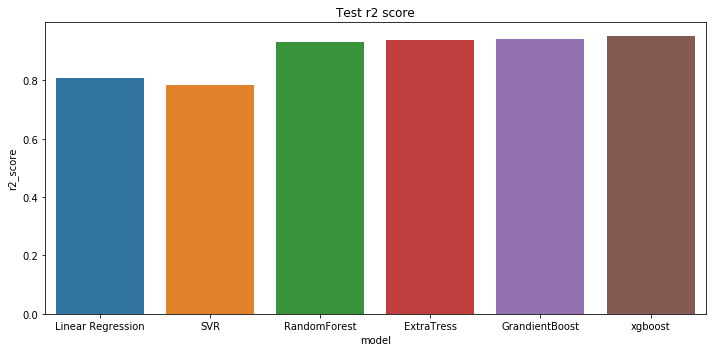

In [174]:
plt.figure(figsize=(10,5))
sns.barplot(x='model', y='r2_score', data=results)
plt.title('Test r2 score')
plt.tight_layout()

## 8 CONCLUSION

Below ML/data analytics tasks were performed to gain insights and maximize the potential to increase cab bookings.

* Exploratory data analysis
* Outlier analysis
* Missing value analysis
* Correlation analysis
* Feature engineering
* Regression Analysis
* Ensemble Modeling
* Predictions/Evaluation

XG Boost regressor yielded the best r2 score on both the train and test sets at 0.95 and the lowest r2 score was from support vector regressor.